In [1]:
from hamp_pred.src.predictor import Predictor
from hamp_pred.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from hamp_pred.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder, MultiEncoder
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt
from Bio.PDB.Polypeptide import aa1
from hamp_pred.src.output_analysis.visual import reg_plot

2022-10-05 15:08:55.921986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# %%bash
# git pull

In [2]:
data = pd.read_pickle('../data/input/full_alpha_data.p')
val_ids = set(data[data['class'] == 'val'].index)
val_data = data.loc[val_ids]
val_fragments = []
val_full = []
for ind, row in val_data.iterrows():
    val_fragments.append(row['n_seq'][1:-1] + row['c_seq'][1:-1])
    val_full.append(row['full_sequence'])
test_data = pd.read_pickle('../data/input/full_pdb_hamp.p')
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)

/var/folders/kd/py7h1wzs6vbgxk8yw70z36cm0000gn/T/ipykernel_30703/2939851312.py:3: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  val_data = data.loc[val_ids]


In [3]:
operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                      parallel=True)
model_conf = model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5, 7),
    'lstm': 2,
    'dense': 1,
    'reshape_out': False,
    'epochs': 100
}
conf = PredictionConfig(BaseConvolutionalWrapper, operator, model_conf)
short_model = Predictor('hamp_rot', config=conf)
full_model = Predictor('hamp_crick_single_sequence')

# Af1503 amino acids importance

## Cutted helices

In [5]:
af_seq_short = test_data.loc['2l7h.pdb']['n_seq'][1:-1] + test_data.loc['2l7h.pdb']['c_seq'][1:-1]

In [6]:
importance = short_model.process_data([af_seq_short], kind='importance_describer', out_kind='heatmap')

2022-10-05 12:58:19.781648: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-05 12:58:21.210034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7390 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1
2022-10-05 12:58:21.214971: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 7388 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1
2022-10-05 12:58:25.014120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2022-10-05 12:58:25.352245: I

1/1 [==============================] - 2s 2s/step


<AxesSubplot:>

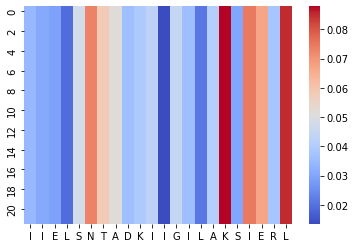

In [7]:
sns.heatmap(importance[0], cmap='coolwarm', xticklabels=importance[1])

## Full sequence

In [17]:
full_importance = full_model.process_data([test_data.loc['2l7h.pdb']['full_sequence']], kind='importance_describer', out_kind='heatmap', res_col='prediction', stats_col='diff')

2/2 [==============================] - 2s 47ms/step


In [11]:
w = full_model.process_data([test_data.loc['2l7h.pdb']['full_sequence']], kind='importance_describer', res_col='prediction')

2/2 [==============================] - 2s 50ms/step


<AxesSubplot:>

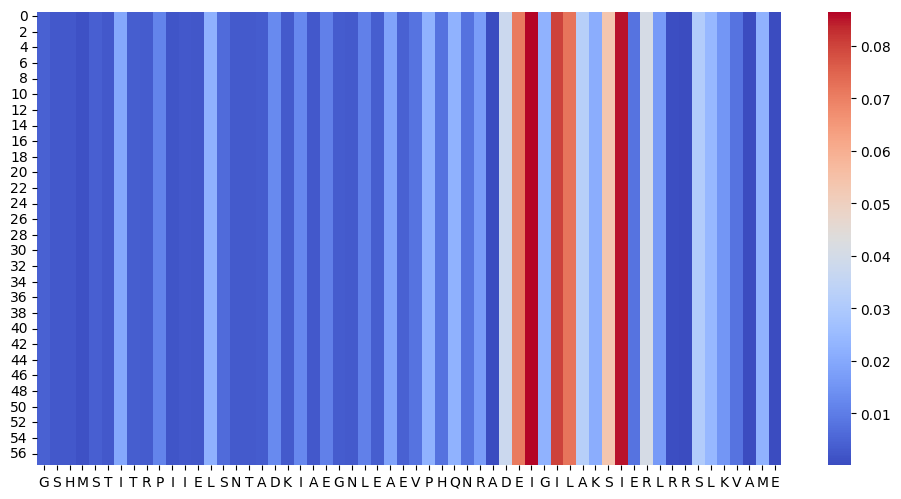

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=100)
sns.heatmap(full_importance[0], cmap='coolwarm', xticklabels=full_importance[1], ax=ax)

## Overall importance (based on validation set)

## Cutted helices

90/90 [==============================] - 3s 15ms/step


<AxesSubplot:>

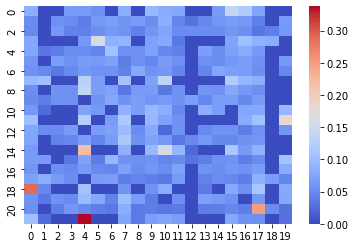

In [21]:
importance = short_model.process_data(val_fragments, kind='importance_describer', out_kind='heatmap')
sns.heatmap(importance[0], cmap='coolwarm')

## Full sequence

2022-10-05 15:10:19.758225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1/1 [==============================] - 2s 2s/step


/Users/awinski/PycharmProjects/HAMPred/hamp_pred/src/input_prep/encode.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([np.array(x) for x in labels])
/Users/awinski/PycharmProjects/HAMPred/hamp_pred/src/input_prep/encode.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ret = np.asarray(res)


149/149 [==============================] - 253s 2s/step


<AxesSubplot: >

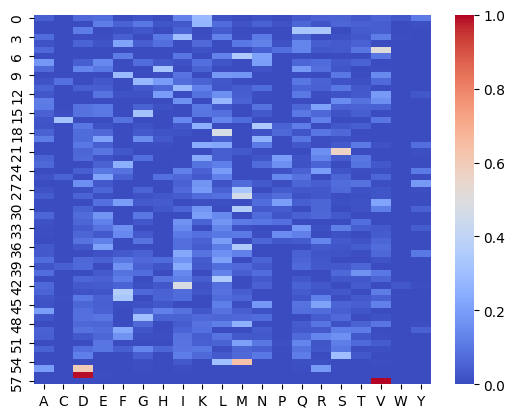

In [9]:
np.random.shuffle(val_full)
importance = full_model.process_data(val_full[:100], kind='importance_describer', out_kind='heatmap', res_col='prediction')
sns.heatmap(importance[0], cmap='coolwarm', xticklabels=list(aa1))